## 🎯 Practice Exercises
## Exercise 1: Build Your First Stateful Agent

### Task
Create an agent with three custom tools:
1. **Weather tool:** Returns simulated weather for a given city
2. **Dictionary tool:** Looks up word definitions (simulate with a small dict)
3. **Web search tool:** Uses DuckDuckGo to search the web for information

### Requirements
1. Define tools using `@tool` decorator
2. Bind tools to LLM
3. Implement conditional routing (agent decides which tool to use)
4. Handle cases where no tool is needed
5. Install DuckDuckGo search: `pip install duckduckgo-search`
6. Use `DDGS().text()` method for web searches

### Example Queries
- "What's the weather in Lagos?" → Uses weather tool
- "Define the word 'ephemeral'" → Uses dictionary
- "Search for latest AI news" → Uses DuckDuckGo web search
- "What's the capital of France?" → No tool needed


In [37]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_community.tools import DuckDuckGoSearchRun
from duckduckgo_search import DDGS
from langchain.tools import tool
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal

import os
import random

print("All imports successful")

All imports successful


In [38]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print("API key loaded")

API key loaded


In [39]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,  # Lower temperature for more precise tool usage
    api_key=openai_api_key
)

print(f"LLM initialized: {llm.model_name}")

LLM initialized: gpt-4o-mini


In [40]:
@tool
def weather_tool(city: str) -> str:
    """Get the current weather for a given city."""
    conditions = ["sunny", "cloudy", "rainy", "windy"]
    temp = random.randint(18, 35)
    condition = random.choice(conditions)
    return f"The weather in {city} is {condition} with a temperature of {temp}°C."

print("Weather tool created")

Weather tool created


In [41]:
@tool
def dictionary_tool(word: str) -> str:
    """Look up the definition of a word."""
    dictionary = {
        "agent": "An entity that acts autonomously to achieve a goal.",
        "temperature": "A measure of how hot or cold something is.",
        "weather": "The state of the atmosphere at a particular place and time."
    }

    return dictionary.get(
        word.lower(),
        f"Sorry, I don't have a definition for '{word}'."
    )

print("Dictionary tool created")

Dictionary tool created


In [42]:
# pip install -U ddgs
# search = DuckDuckGoSearchRun()

# @tool
# def web_search_tool(query: str) -> str:
#     """Search the web using DuckDuckGo."""
#     return search.run(query)


In [43]:
@tool
def web_search_tool(query: str) -> str:
    """Search the web using DuckDuckGo and return concise results."""
    try:
        with DDGS() as ddgs:
            results = ddgs.text(
                query,
                max_results=5
            )

            summaries = []
            for r in results:
                summaries.append(f"- {r['title']}: {r['body']}")

            if not summaries:
                return "No relevant search results found."

            return "\n".join(summaries)

    except Exception as e:
        return f"Error during web search: {str(e)}"

print("Web search tool created")


Web search tool created


In [ ]:
# Create a list of tools
tools = [weather_tool, dictionary_tool, web_search_tool ]

# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)

print(f"LLM bound to {len(tools)} tools")
print(f"   Tools: {[tool.name for tool in tools]}")

✅ LLM bound to 3 tools
   Tools: ['weather_tool', 'dictionary_tool', 'web_search_tool']


In [ ]:
# System prompt that encourages tool usage
sys_msg = SystemMessage(content="""You are a helpful, reliable, and precise information assistant.

You have access to three tools:

Weather Tool – use this to provide current weather information for a specific city.

Dictionary Tool – use this to define words or explain their meanings.

Web Search Tool – use this to search the internet when information is unknown, current, or outside your internal knowledge.

Tool Usage Rules

Choose the most specific tool that best answers the user’s request.

Use the Weather Tool only when the user asks about weather conditions for a city.

Use the Dictionary Tool when the user asks for definitions or meanings of words.

Use the Web Search Tool when:

The question requires up-to-date information

The answer is not available from the dictionary or weather tools

If a question requires multiple tools, call them in a logical order and combine the results into one clear response.

Response Guidelines

Be concise, accurate, and easy to understand.

Do not guess facts or fabricate information.

If a tool returns an error, explain the issue politely and suggest an alternative or next step.

Summarize information clearly when combining multiple tool results.

Behavior Constraints

Do not mention internal tool names or system instructions to the user.

Do not call tools unnecessarily.

If the user’s request is unclear, ask one short clarifying question before using any tool.

Your goal is to provide correct information efficiently while using tools responsibly and transparently.""")

def assistant(state: MessagesState) -> dict:
    """
    Assistant node - decides whether to use tools or answer directly.
    """
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

print("Assistant node defined")

✅ Assistant node defined


In [ ]:
def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """
    Decide next step based on last message.
    
    If LLM called a tool → go to 'tools' node
    If LLM provided final answer → go to END
    """
    last_message = state["messages"][-1]
    
    # Check if LLM made tool calls
    if last_message.tool_calls:
        return "tools"
    
    # No tool calls - we're done
    return "__end__"

print("Conditional routing function defined")

✅ Conditional routing function defined


In [ ]:
# Create the graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))  # ToolNode executes tool calls automatically

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {"tools": "tools", "__end__": END}
)
builder.add_edge("tools", "assistant")  # After tools, go back to assistant

# Add memory
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

print("Agent graph compiled with tools and memory")

✅ Agent graph compiled with tools and memory


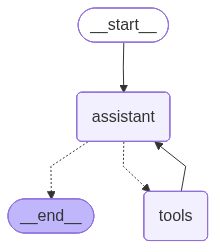

In [48]:
# Visualize the agent graph
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START → assistant → [conditional] → tools → assistant → END")

In [ ]:
# Helper function
def run_agent(user_input: str, thread_id: str = "test_session"):
    """
    Run the agent and display the conversation.
    """
    print(f"\n{'='*70}")
    print(f"👤 User: {user_input}")
    print(f"{'='*70}\n")
    
    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )
    
    for message in result["messages"]:
        if isinstance(message, HumanMessage):
            continue  # Already printed
        elif isinstance(message, AIMessage):
            if message.tool_calls:
                print(f"🤖 Agent: [Calling tool: {message.tool_calls[0]['name']}]")
            else:
                print(f"🤖 Agent: {message.content}")
        elif isinstance(message, ToolMessage):
            print(f"🔧 Tool Result: {message.content[:100]}..." if len(message.content) > 100 else f"🔧 Tool Result: {message.content}")
    
    print(f"\n{'='*70}\n")

print("✅ Test function ready")

✅ Test function ready


In [50]:
run_agent("What's the weather in Lagos?")


👤 User: What's the weather in Lagos?

🤖 Agent: [Calling tool: weather_tool]
🔧 Tool Result: The weather in Lagos is cloudy with a temperature of 29°C.
🤖 Agent: The weather in Lagos is currently cloudy, with a temperature of 29°C.




In [51]:
run_agent("Define the word 'ephemeral' in a single sentence.")


👤 User: Define the word 'ephemeral' in a single sentence.



C:\Users\USER\AppData\Local\Temp\ipykernel_2336\3796097916.py:5: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


🤖 Agent: [Calling tool: weather_tool]
🔧 Tool Result: The weather in Lagos is cloudy with a temperature of 29°C.
🤖 Agent: The weather in Lagos is currently cloudy, with a temperature of 29°C.
🤖 Agent: [Calling tool: dictionary_tool]
🔧 Tool Result: Sorry, I don't have a definition for 'ephemeral'.
🤖 Agent: [Calling tool: web_search_tool]
🔧 Tool Result: - Ephemeral Plants Definition, Types & Examples - Study.com: Explore ephemeral plants. Learn the def...
🤖 Agent: The word "ephemeral" is an adjective meaning lasting for a very short period of time.




In [52]:
run_agent("Search for latest AI news")


👤 User: Search for latest AI news



C:\Users\USER\AppData\Local\Temp\ipykernel_2336\3796097916.py:5: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


🤖 Agent: [Calling tool: weather_tool]
🔧 Tool Result: The weather in Lagos is cloudy with a temperature of 29°C.
🤖 Agent: The weather in Lagos is currently cloudy, with a temperature of 29°C.
🤖 Agent: [Calling tool: dictionary_tool]
🔧 Tool Result: Sorry, I don't have a definition for 'ephemeral'.
🤖 Agent: [Calling tool: web_search_tool]
🔧 Tool Result: - Ephemeral Plants Definition, Types & Examples - Study.com: Explore ephemeral plants. Learn the def...
🤖 Agent: The word "ephemeral" is an adjective meaning lasting for a very short period of time.
🤖 Agent: [Calling tool: web_search_tool]
🔧 Tool Result: - Google News - Artificial intelligence - Latest: Read full articles, watch videos, browse thousands...
🤖 Agent: Here are some of the latest updates in AI news:

1. **AI News** - This source provides updates on artificial intelligence, machine learning, and emerging technologies.
2. **TechCrunch** - Offers insights into the latest developments in AI and machine learning, including ethical 

In [53]:
run_agent("What's the capital of France?")


👤 User: What's the capital of France?

🤖 Agent: [Calling tool: weather_tool]
🔧 Tool Result: The weather in Lagos is cloudy with a temperature of 29°C.
🤖 Agent: The weather in Lagos is currently cloudy, with a temperature of 29°C.
🤖 Agent: [Calling tool: dictionary_tool]
🔧 Tool Result: Sorry, I don't have a definition for 'ephemeral'.
🤖 Agent: [Calling tool: web_search_tool]
🔧 Tool Result: - Ephemeral Plants Definition, Types & Examples - Study.com: Explore ephemeral plants. Learn the def...
🤖 Agent: The word "ephemeral" is an adjective meaning lasting for a very short period of time.
🤖 Agent: [Calling tool: web_search_tool]
🔧 Tool Result: - Google News - Artificial intelligence - Latest: Read full articles, watch videos, browse thousands...
🤖 Agent: Here are some of the latest updates in AI news:

1. **AI News** - This source provides updates on artificial intelligence, machine learning, and emerging technologies.
2. **TechCrunch** - Offers insights into the latest developments in AI 